In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Markdown

%matplotlib inline

In [2]:
%%html 
<style>
table {float:left; border-style: solid;}
</style>

Utils

In [3]:
# util to classify variables into categorical or quantitative
def classify_variables(df: pd.DataFrame):
    '''
    Given a dataframe, returns two lists: a list of the categorical variables 
    in the dataframe and a list of the quantitative ones, based on the dtypes.
    '''
    cols = df.columns.to_list()
    quantitative_cols = df.select_dtypes('number').columns.to_list()
    categorical_cols = df.select_dtypes('object').columns.to_list()
    display(Markdown("#### Features in the dataset"))
    print("Count:", len(cols), "\nFeatures:", cols)
    display(Markdown("#### Categorical Features"))
    print("Count:", len(categorical_cols), "\nFeatures:", categorical_cols)
    display(Markdown("#### Continuous Features"))
    print("Count:", len(quantitative_cols), "\nFeatures:", quantitative_cols)
    return categorical_cols, quantitative_cols

def count_outliers(df:pd.DataFrame, var:str):
    '''Returns count of outliers.'''
    q25 = df[var].quantile(0.25)
    q75 = df[var].quantile(0.75)
    iqr = q75 - q25 
    outliers = df[(df[var] < q25 - 1.5*iqr) | (df[var] > q75 + 1.5*iqr)][var]
    return len(outliers)

def get_clamp_thresholds(df:pd.DataFrame, var:str):
    '''
    Return clamp threshold based on 1.5IQR criterion:
    (first_quartile - 1.5IQR, third_quartile + 1.5IQR)
    '''
    q25 = df[var].quantile(0.25)
    q75 = df[var].quantile(0.75)
    iqr = q75 - q25
    lower = q25 - 1.5*iqr
    upper = q75 + 1.5*iqr
    return (lower, upper)

In [4]:
# importing the dataset
data_path = 'data/'
file_name = 'Auto.csv'
auto_df = pd.read_csv(data_path+file_name)
display(auto_df.shape)
auto_df.info()
auto_df.head()

(397, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [5]:
# Observations:
# horsepower's data type has been identified as 'object' despite of representing numeric values. 
# This means that there are non-numeric values for this feature, suggesting missing or invalid data.
# To have a better idea of what's going on, I checked if pandas raises any parsing errors when I try the following line: auto_df['horsepower'] = pd.to_numeric(auto_df['horsepower'])
# As suspected, there are invalid values for 'horsepower', the code above resulting in --> ValueError: Unable to parse string "?" at position 32.

# checking the instances with this issue
auto_df[auto_df.horsepower=='?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i


In [6]:
# There are 5 entries with horsepower = ?
# I will replace "?" with Nan so I can treat them as missing values without affecting the data type of the feature.
auto_df['horsepower'].replace('?', np.NaN, inplace=True)

# updating data type and checking data types again
auto_df['horsepower'] = pd.to_numeric(auto_df['horsepower'])
auto_df.info()

# Observations: data types seem fine now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.0+ KB


In [7]:
# classifying features in quantitative and categorical based on the variable dtype
cat_cols, cont_cols = classify_variables(auto_df)

#### Features in the dataset

Count: 9 
Features: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']


#### Categorical Features

Count: 1 
Features: ['name']


#### Continuous Features

Count: 8 
Features: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']


**Continuous features**

In [8]:
# descriptive statistics
auto_df[cont_cols].describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,397.000000,397.000000,397.000000,392.000000,397.000000,397.000000,397.000000,397.000000
mean,23.515869,5.458438,193.532746,104.469388,2970.261965,15.555668,75.994962,1.574307
std,7.825804,1.701577,104.379583,38.491160,847.904119,2.749995,3.690005,0.802549
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.000000,75.000000,2223.000000,13.800000,73.000000,1.000000
50%,23.000000,4.000000,146.000000,93.500000,2800.000000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3609.000000,17.100000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [9]:
# checking missing values
auto_df[cont_cols].isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      5
weight          0
acceleration    0
year            0
origin          0
dtype: int64

#### Feature Cardinality

mpg             129
cylinders         5
displacement     82
horsepower       93
weight          350
acceleration     95
year             13
origin            3
dtype: int64

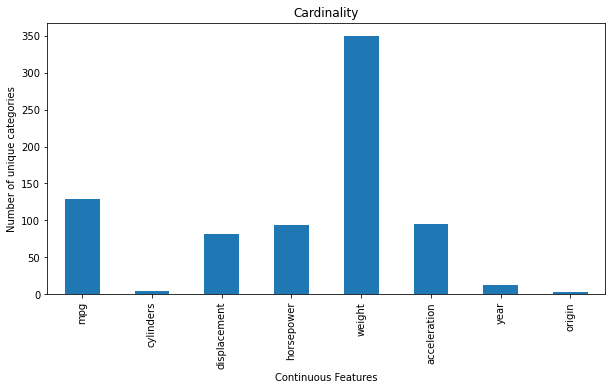

In [10]:
# cardinality
display(Markdown("#### Feature Cardinality"))
display(auto_df[cont_cols].nunique())

# visualizing cardinality of continuous features
auto_df[cont_cols].nunique(dropna=False).plot.bar(figsize=(10,5))
plt.ylabel('Number of unique categories')
plt.xlabel('Continuous Features')
plt.title('Cardinality')
plt.show()

# Observations:
# - Origin has low cardinality, 3. This fact, along with the name of the feature, suggests that this feature represents a categorical variable that was encoded using numbers. Without more information about this dataset, it is difficult to know the right mapping for the values. This feature will be treated as categorical despite of its numeric values. I assume it represents region of origin, probably, country or continent. Ideally, business would provide the right mapping.
# - Cylinders has low cardinality but it is appropriate based on context.

# removing origin from the continuous variables list and adding it to the categorical one:
cont_cols.remove('origin')
cat_cols.append('origin')

#### Outliers Summary

mpg: 1
cylinders: 0
displacement: 0
horsepower: 10
weight: 0
acceleration: 10
year: 0


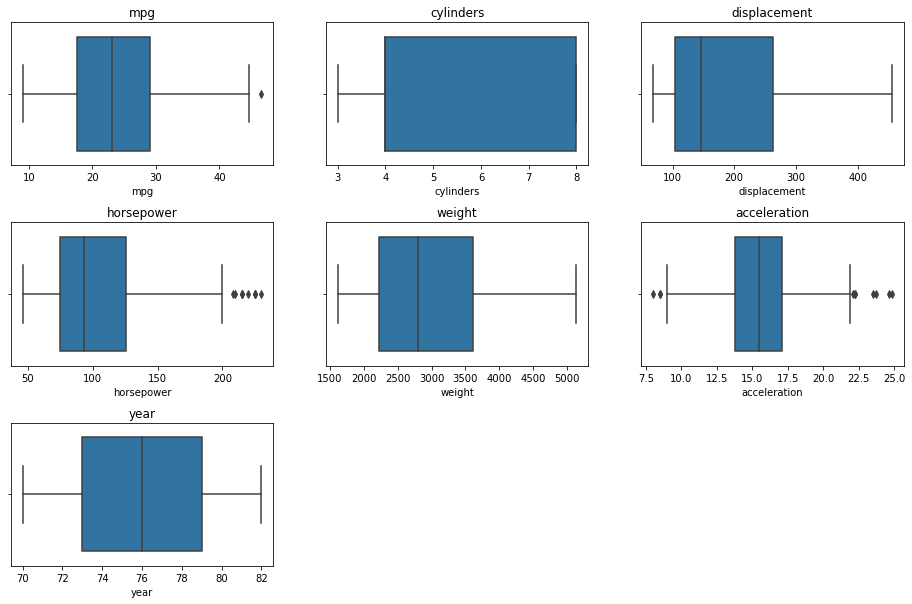

In [11]:
# summarizing outliers count
display(Markdown("#### Outliers Summary"))
for var in cont_cols:
    outliers_count = count_outliers(auto_df, var)
    print("%s: %d" %(var, outliers_count))
    
# visualizing with boxplots
x_ax = cont_cols[:]

fig_cols = 3
fig_rows = -(-len(x_ax)//fig_cols)
plots_qty = len(x_ax)

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(16,10), gridspec_kw={'hspace': 0.4})
for i in range(plots_qty):
    row = i // fig_cols
    col = i % fig_cols
    ax_curr = axes[row, col]
    sns.boxplot(x=x_ax[i], data=auto_df, ax=ax_curr)
    ax_curr.set_title(x_ax[i])
    
to_set_off = fig_cols * fig_rows - plots_qty
for i in range(1, to_set_off+1):
    axes.flat[-i].set_visible(False)
    
# Observations:
# - According to the 1.5IQR criterion, there are outliers for mpg, horsepower, and acceleration.
# - I am not an expert in cars, but web research showed that the Mazda GLC of 1980 could indeed reach this MPG value of 46.6, which is an outlier in the data. Without more information about the dataset, it is assumed to be a valid outlier.
# - Horsepower has the maximum value of 230. Research showed that this is a valid value, even for cars from the 70s and 80s. Therefore, it is assumed this is a valid outlier in the data.
# - Research confirmed that the values of acceleration's outliers are valid.

In [12]:
auto_df[auto_df.mpg==46.6]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
322,46.6,4,86.0,65.0,2110,17.9,80,3,mazda glc


In [13]:
auto_df[(auto_df.acceleration<=8.5) | (auto_df.acceleration>22)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii
9,15.0,8,390.0,190.0,3850,8.5,70,1,amc ambassador dpl
11,14.0,8,340.0,160.0,3609,8.0,70,1,plymouth 'cuda 340
59,23.0,4,97.0,54.0,2254,23.5,72,2,volkswagen type 3
195,29.0,4,85.0,52.0,2035,22.2,76,1,chevrolet chevette
196,24.5,4,98.0,60.0,2164,22.1,76,1,chevrolet woody
299,27.2,4,141.0,71.0,3190,24.8,79,2,peugeot 504
300,23.9,8,260.0,90.0,3420,22.2,79,1,oldsmobile cutlass salon brougham
326,43.4,4,90.0,48.0,2335,23.7,80,2,vw dasher (diesel)
393,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup


In [14]:
# determining potential thresholds for features with outliers using the 1.5IQR criterion
outl = ['mpg', 'horsepower', 'acceleration']
for var in outl:
    print(var, get_clamp_thresholds(auto_df, var))

mpg (0.25, 46.25)
horsepower (-1.5, 202.5)
acceleration (8.85, 22.050000000000004)


<AxesSubplot:>

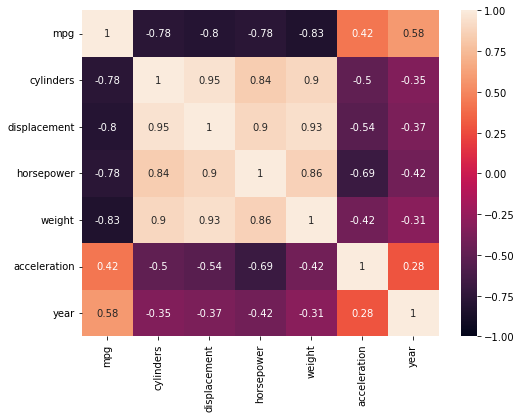

In [15]:
# collinearity
fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(auto_df[cont_cols].corr(), vmin=-1, vmax=1, annot=True)

# Observations:
# - year and acceleration depict a relatively high positive correlation with mpg.
# - cylinders, displacement, horsepower, and weight are moderately correlated.
# - cylinders, displacement, horsepower, and weight show a significant negative correlation with mpg and also with acceleration.

**Visualizing feature distributions**

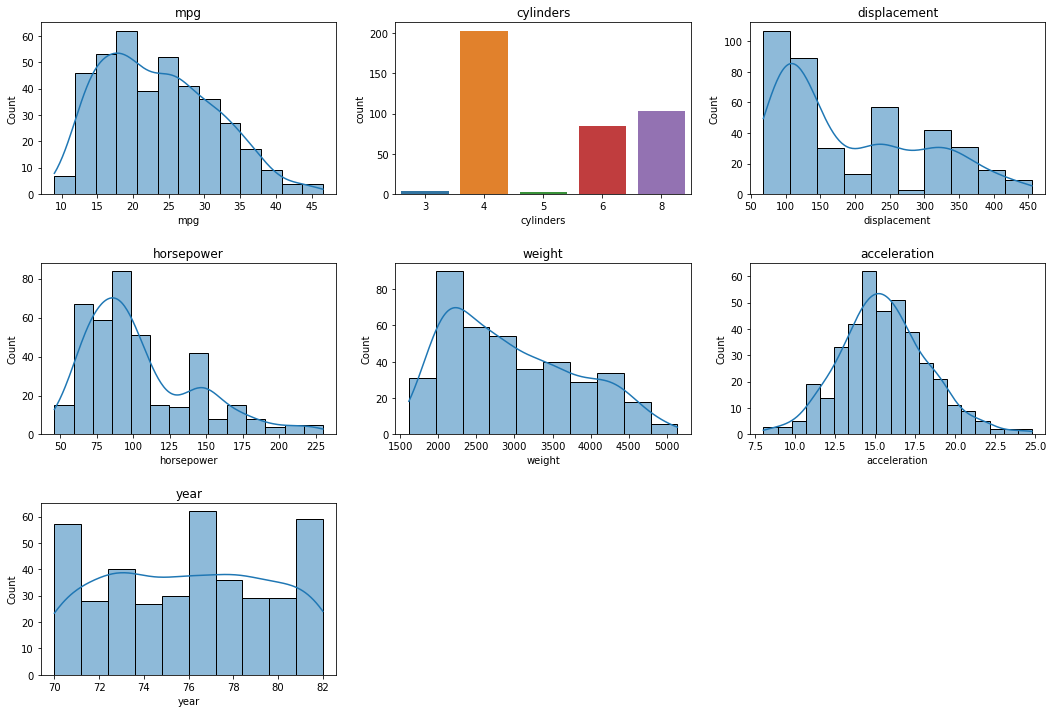

In [16]:
# x_axis
x_ax = cont_cols[:]

fig_cols = 3
fig_rows = -(-len(x_ax)//fig_cols)
plots_qty = len(x_ax)

# plotting histogram and/or bar plot
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(18,12), gridspec_kw={'hspace': 0.4})
for i in range(plots_qty):
    row = i // fig_cols
    col = i % fig_cols
    ax_curr = axes[row, col]
    
    if(x_ax[i] == 'cylinders'): # for features with cardinality < 10, I'll use a bar plot instead of a histogram.
        sns.countplot(x=x_ax[i], data=auto_df, ax=ax_curr)
    else:
        sns.histplot(data=auto_df, x=x_ax[i], kde=True, ax=ax_curr)
        
    ax_curr.set_title(x_ax[i])
    
to_set_off = fig_cols * fig_rows - plots_qty
for i in range(1, to_set_off+1):
    axes.flat[-i].set_visible(False)
    
# Observations:
# - mpg follows a skewed-right distribution. Data is centred at 23 with very close mean and median at 23.5 and 23 respectively.
# - displacement follows a skewed-right distribution. The data is centred at 146 and there is a significant variation in the top 50% of the data.
# - year ranges from 70 to 82 and it follows a uniform distribution.
# - acceleration follows a roughly normal distribution centred at 15.5.
# - the vast majority of instances have horsepower less than 126.
# - most autos have 4 cylinders followed by 8. 3 and 5 cylinders are the least frequent.

**Visualizing relationships between descriptive features and target**

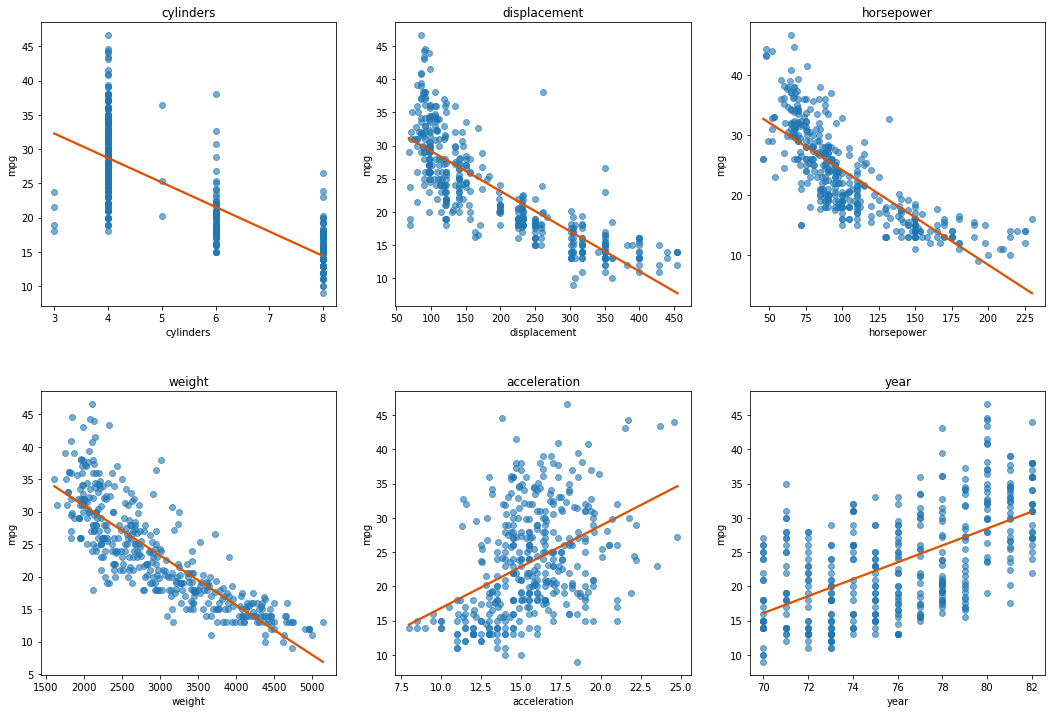

In [17]:
# x_axis
x_ax = cont_cols[:] # list of variables for the x_axis
x_ax.remove('mpg')
y_ax = 'mpg' # y_axis

fig_cols = 3
fig_rows = -(-len(x_ax)//fig_cols)
plots_qty = len(x_ax)

# plotting with reg line
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(18,12), gridspec_kw={'hspace': 0.3})
for i in range(plots_qty):
    row = i // fig_cols
    col = i % fig_cols
    ax_curr = axes[row, col]
    sns.regplot(x=x_ax[i], y=y_ax, ci=None, data=auto_df, line_kws={"color": "#dc5200"}, scatter_kws={"alpha": 0.6}, ax=ax_curr);
    ax_curr.set_title(x_ax[i])
    
to_set_off = fig_cols * fig_rows - plots_qty
for i in range(1, to_set_off+1):
    axes.flat[-i].set_visible(False)
    
# Observations:
# - the following plots visually depict what was mentioned before while examining the correlation matrix.
# - mpg tends to increase when acceleration or year increases.
# - mpg tends to decrease when the number of cylinders, displacement, horsepower, or weight increases.
# - these correlations make sense in the corresponding context.

**Categorical Features**

In [18]:
auto_df['name'].describe()

count            397
unique           304
top       ford pinto
freq               6
Name: name, dtype: object

In [19]:
# checking modes and frequency
display(Markdown("#### Frequency of categorical features"))
for var in cat_cols:
    print(f'\nFeature: {var} (top 5)')
    feature_count = auto_df[var].value_counts(dropna=False)
    feature_per = auto_df[var].value_counts(dropna=False, normalize=True)*100
    display(pd.concat([feature_count,feature_per], axis=1, keys=['counts', '%']).iloc[:5])

#### Frequency of categorical features


Feature: name (top 5)


,counts,%
ford pinto,6,1.511335
amc matador,5,1.259446
ford maverick,5,1.259446
toyota corolla,5,1.259446
toyota corona,4,1.007557



Feature: origin (top 5)


,counts,%
1,248,62.468514
3,79,19.899244
2,70,17.632242


In [20]:
# checking missing values
auto_df[cat_cols].isna().sum()

name      0
origin    0
dtype: int64

**Visualizing feature distributions**

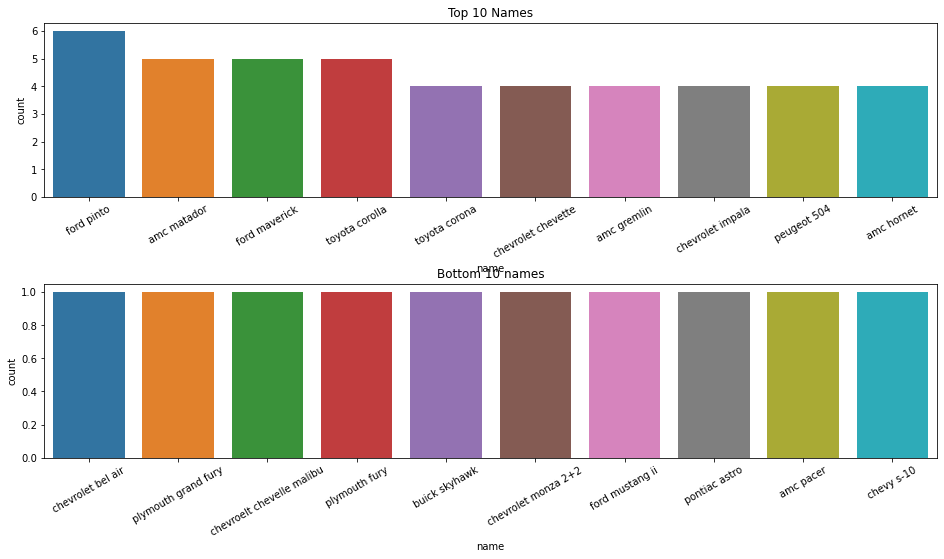

In [21]:
# considering the high cardinality of name (304 unique values), I will plot only the top 10 and bottom 10
fig, ax = plt.subplots(2,1, figsize=(16,8), gridspec_kw={'hspace': 0.5})
p1 = sns.countplot(x='name', data=auto_df, ax=ax[0], order=auto_df.name.value_counts().iloc[:10].index).set_title('Top 10 Names')
p2 = sns.countplot(x='name', data=auto_df, ax=ax[1], order=auto_df.name.value_counts().iloc[-10:].index).set_title('Bottom 10 names')

for i in range(2):
    ax[i].tick_params('x', labelrotation=30)

Text(0.5, 1.0, 'Origin')

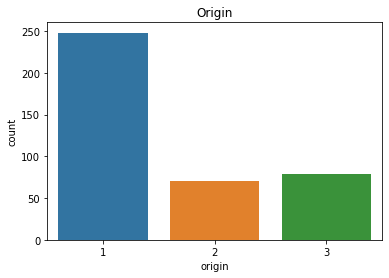

In [22]:
sns.countplot(x='origin', data=auto_df).set_title('Origin')

In [23]:
# Observations:
# - ford pinto is the make/model most represented, but by a significantly small margin.
# - all three 'amc matador', 'ford maverick', and 'toyota corolla' are tied in second place following ford pinto.
# - origin=1 is the most frequent with over 60% of the data.

**Visualizing relationships between descriptive features and target**

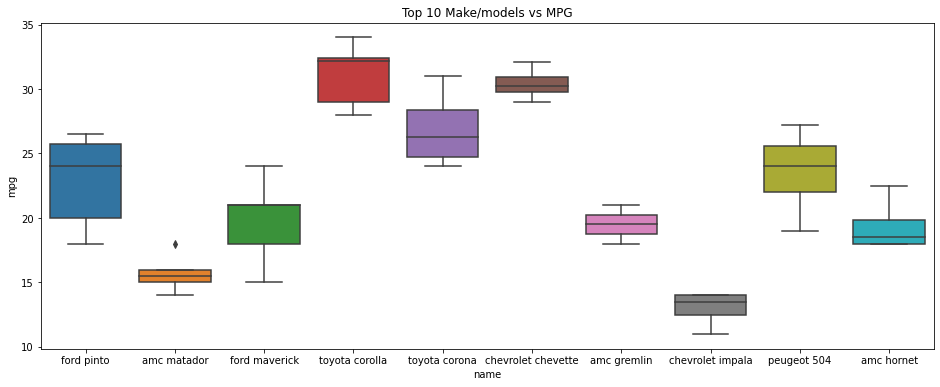

In [24]:
fig, ax = plt.subplots(figsize=(16,6)) 
sns.boxplot(x='name', y='mpg', data=auto_df, order=auto_df.name.value_counts().iloc[:10].index).set_title('Top 10 Make/models vs MPG')
plt.show()

In [25]:
display(Markdown('#### Top 3 Make/models by MPG'))
auto_df.sort_values(by='mpg', ascending=False).iloc[:3][['mpg', 'name']]

#### Top 3 Make/models by MPG

,mpg,name
322,46.6,mazda glc
329,44.6,honda civic 1500 gl
325,44.3,vw rabbit c (diesel)


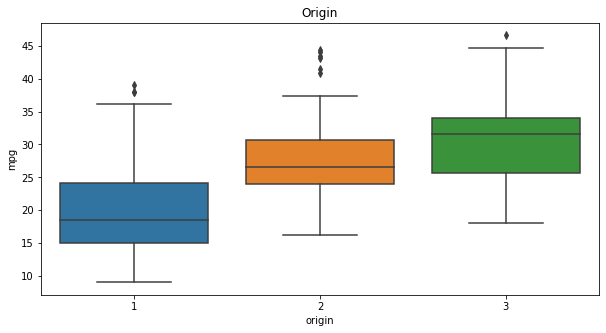

In [26]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.boxplot(x='origin', y='mpg', data=auto_df).set_title('Origin')
plt.show()

In [27]:
# Observations:
# - Each make/model relates differently to mpg.
# - Mazda GLC, Honda Civic 155 gl, and VW Rabbit C are top 3 make/models by MPG.
# - Cars from origin 3 cover a higher range of MPG while cars from origin 1 tend to have the lowest range of MPG values.